In [16]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

class GraphHierarchicalRetriever:
    def __init__(self, df_concepts, df_papers, cluster_column='Cluster', embedding_model='all-MiniLM-L6-v2'):
        self.df_concepts = df_concepts.copy()
        self.df_papers = df_papers.copy()
        self.cluster_column = cluster_column

        # Clean column names
        self.df_concepts.columns = self.df_concepts.columns.str.strip()
        self.df_papers.columns = self.df_papers.columns.str.strip()

        # Ensure proper column naming
        if 'Title' not in self.df_concepts.columns and 'name' in self.df_concepts.columns:
            self.df_concepts['Title'] = self.df_concepts['name']
        if 'Unnamed: 5' in self.df_papers.columns:
            self.df_papers.drop(columns=['Unnamed: 5'], inplace=True)

        # Sentence embedding model
        self.model = SentenceTransformer(embedding_model)

        # Create embeddings for concepts
        self.df_concepts['CombinedText'] = self.df_concepts['Title'].fillna('') + ". " + self.df_concepts.get('description', '').fillna('')
        self.embeddings = self.model.encode(self.df_concepts['CombinedText'].tolist(), show_progress_bar=True)

        # Compute cluster centroids
        self.cluster_centroids = self._compute_cluster_centroids()

    def _compute_cluster_centroids(self):
        centroids = {}
        for cluster_id in self.df_concepts[self.cluster_column].unique():
            indices = self.df_concepts[self.df_concepts[self.cluster_column] == cluster_id].index
            cluster_embeds = self.embeddings[indices]
            centroids[cluster_id] = np.mean(cluster_embeds, axis=0)
        return centroids

    def find_top_clusters(self, query_embedding, top_n=3):
        cluster_ids = list(self.cluster_centroids.keys())
        centroid_vectors = np.array([self.cluster_centroids[c] for c in cluster_ids])
        similarities = cosine_similarity(query_embedding, centroid_vectors)[0]
        top_indices = similarities.argsort()[::-1][:top_n]
        return [cluster_ids[i] for i in top_indices]

    def retrieve_concepts_within_clusters(self, query_embedding, selected_clusters, top_k_concepts=5):
        df_filtered = self.df_concepts[self.df_concepts[self.cluster_column].isin(selected_clusters)].copy()
        filtered_embeddings = self.embeddings[df_filtered.index]
        sim_scores = cosine_similarity(query_embedding, filtered_embeddings)[0]
        top_indices = sim_scores.argsort()[::-1][:top_k_concepts]
        df_filtered = df_filtered.iloc[top_indices].copy()
        df_filtered['Similarity Score'] = sim_scores[top_indices]
        return df_filtered

    def get_papers_for_concepts_semantic(self, concept_results, top_k=1):
        paper_texts = self.df_papers['Title'].fillna('').tolist()
        paper_embeddings = self.model.encode(paper_texts, show_progress_bar=True)

        matched_papers = []

        for idx, row in concept_results.iterrows():
            concept_text = f"{row['Title']}. {row.get('description', '')}"
            concept_embedding = self.model.encode([concept_text])

            sim_scores = cosine_similarity(concept_embedding, paper_embeddings)[0]
            top_indices = sim_scores.argsort()[::-1][:top_k]

            for i in top_indices:
                matched_papers.append({
                    'Matched Concept': row['Title'],
                    'MatchedPaperTitle': self.df_papers.iloc[i]['Title'],
                    'SemanticScore': sim_scores[i],
                    'Authors': self.df_papers.iloc[i].get('Authors', ''),
                    'PDF': self.df_papers.iloc[i].get('URL for pdf', '')
                })

        return pd.DataFrame(matched_papers)

    def hierarchical_query(self, paragraph, top_clusters=3, top_k_concepts=5, top_k_papers=1):
        query_embedding = self.model.encode([paragraph])
        selected_clusters = self.find_top_clusters(query_embedding, top_clusters)
        concept_results = self.retrieve_concepts_within_clusters(query_embedding, selected_clusters, top_k_concepts)
        paper_results = self.get_papers_for_concepts_semantic(concept_results, top_k=top_k_papers)
        return selected_clusters, concept_results, paper_results

In [17]:
# Load CSV files
df_concepts = pd.read_csv("leiden_clusters.csv")
df_papers = pd.read_csv("Paper Info.csv")

# Initialize retriever
retriever = GraphHierarchicalRetriever(df_concepts, df_papers, cluster_column='Cluster')

# Sample query
query_paragraph = """A common approach these days is using paged attention mechanism for KV cache management 
but we propose that the traditional contiguous mechanism is better suited for local offline processing."""

# Perform hierarchical graph retrieval
top_clusters, concept_results, paper_results = retriever.hierarchical_query(
    paragraph=query_paragraph,
    top_clusters=3,
    top_k_concepts=5,
    top_k_papers=1
)

# Display results
print("\n--- Top Clusters ---")
print(top_clusters)

print("\n--- Top Matching Concepts ---")
print(concept_results[['Cluster', 'Title', 'Similarity Score', 'description']])

print("\n--- Matching Papers ---")
print(paper_results[['Matched Concept', 'MatchedPaperTitle', 'SemanticScore', 'Authors', 'PDF']])


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]


--- Top Clusters ---
[5, 15, 2]

--- Top Matching Concepts ---
    Cluster                        Title  Similarity Score  \
36        5               PagedAttention          0.483848   
97       15         Spatial Partitioning          0.402051   
76        2       Switchable parallelism          0.364006   
98       15  Prefill and Decoding Phases          0.352158   
38        5                       S-LoRA          0.342209   

                                          description  
36  Custom attention mechanism with reduced comput...  
97  Allocating separate groups of GPUs for each LL...  
76  A method for dynamically adjusting the level o...  
98  Phases in LLM serving where memory resources c...  
38  Scalable serving system for thousands of LoRA ...  

--- Matching Papers ---
               Matched Concept  \
0               PagedAttention   
1         Spatial Partitioning   
2       Switchable parallelism   
3  Prefill and Decoding Phases   
4                       S-LoRA  

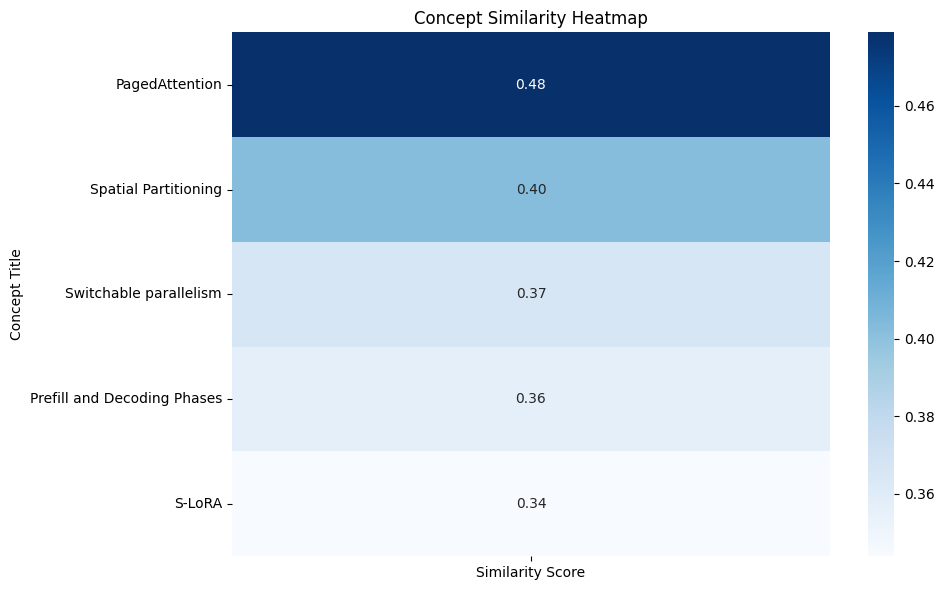

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmap(concept_results_df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(concept_results_df[['Similarity Score']].set_index(concept_results_df['Title']), 
                annot=True, cmap='Blues', fmt=".2f")
    plt.title("Concept Similarity Heatmap")
    plt.ylabel("Concept Title")
    plt.tight_layout()
    plt.show()

plot_similarity_heatmap(concepts)

In [6]:
def style_concept_results(concept_results_df):
    return concept_results_df[['Cluster', 'Title', 'Similarity Score', 'description']].style\
           .background_gradient(cmap='YlGnBu', subset=['Similarity Score'])\
           .set_caption("Top Matching Concepts with Similarity Highlight")

style_concept_results(concepts)

,Cluster,Title,Similarity Score,description
36,5,PagedAttention,0.478947,Custom attention mechanism with reduced computational complexity and improved memory efficiency
97,15,Spatial Partitioning,0.402203,Allocating separate groups of GPUs for each LLM to accommodate their large model size and the key-value cache
76,2,Switchable parallelism,0.365732,A method for dynamically adjusting the level of parallelism based on the workload.
98,15,Prefill and Decoding Phases,0.356484,Phases in LLM serving where memory resources can be multiplexed
38,5,S-LoRA,0.343935,Scalable serving system for thousands of LoRA adapters
